# Cifar10 classification tricks

In this notebook you will download the cifar10 dataset which contains quite small images (32x32x3) of 10 classes. The data is from the Canadian Institute For Advanced Research. You will plot examples of the images with the class label. Note that because the images are so small it is not always very easy to recognise which of the ten classes is on the image, even as a human.  

After loading the dataset you will train a model with the some best practices for deep learning and compare the performances on the testset. 

You can load weights from two different opimizers (adam and sgd). Compare the learning history of theses two.

**Dataset:**  You work with the Cifar10 dataset. You have 60'000 32x32 pixel color images of 10 classes ("airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck")

**Content:**
* load the original cifar10 data create a train val and test dataset
* visualize samples of cifar10 dataset

* train a model with the best practices for deep learning
    - use normalization
    - use dropout
    - use batch normalization
    - use data augmentation
    - use early stopping (via checkpointing)
  

* compare the performances of the models


#### Imports

In the next two cells, we load all the required libraries and functions.

In [1]:
# load required libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl

%matplotlib inline
plt.style.use('default')
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras import optimizers
from sklearn.ensemble import RandomForestClassifier


In [2]:
train = False
model_name = "my_cifar10_model_adam"


### Load and plot the data

In the next cell you will load the Cifar10 dataset, 50'000 images are in the training set and 10'000 are in the test dataset. You will use 10'000 for the train and validation dataset.
You will plot one random example of each label and will see
that the images are really small and finally you can convert the lables into the one hot encoding.


In [3]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
# separate train val and test dataset
X_train=x_train[0:10000] 
Y_train=to_categorical(y_train[0:10000],10) # one-hot encoding

X_val=x_train[20000:30000] 
Y_val=to_categorical(y_train[20000:30000],10)

X_test=x_test 
Y_test=to_categorical(y_test,10)

del x_train, y_train, x_test, y_test


print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(10000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


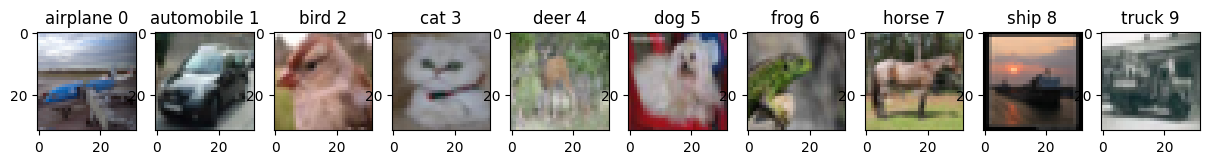

In [5]:
labels=np.array(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])
#sample image of each label
plt.figure(figsize=(15,15))
for i in range(0,len(np.unique(np.argmax(Y_train,axis=1)))):
    rmd=np.random.choice(np.where(np.argmax(Y_train,axis=1)==i)[0],1)
    plt.subplot(1,10,i+1)
    img=X_train[rmd]
    plt.imshow(img[0,:,:,:])
    plt.title(labels[i]+" "+str(np.argmax(Y_train,axis=1)[rmd][0]))

In [6]:
# check the shape of the data
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((10000, 32, 32, 3), (10000, 10), (10000, 32, 32, 3), (10000, 10))

In [7]:
# normalization
X_train_norm = X_train/255
X_val_norm = X_val/255
X_test_norm = X_test/255

In [8]:
tf.__version__

'2.4.0'

### CNN from scratch with normalization
In this section you train a cnn from scratch to learn to classify the images into the right label. Normalization is applied to the data.

In [9]:
# set seed for initializer. 
# however, does not yield the exact same results for each time the model is trained.
tf.random.set_seed(0)

In [10]:
model  =  Sequential()

model.add(BatchNormalization(input_shape=(32,32,3)))

model.add(Convolution2D(32,(3,3),padding="same", activation = "relu"))
model.add(BatchNormalization())
model.add(Convolution2D(32,(3,3),padding="same", activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Convolution2D(64,(3,3),padding="same", activation = "relu"))
model.add(BatchNormalization())
model.add(Convolution2D(64,(3,3),padding="same", activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

model.add(Convolution2D(128,(3,3),padding="same", activation = "relu"))
model.add(BatchNormalization())
model.add(Convolution2D(128,(3,3),padding="same", activation = "relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.4))

model.add(Dense(10, activation = "softmax"))

model.compile(
    loss='categorical_crossentropy',
    optimizer = keras.optimizers.Adam(learning_rate=1*1e-4), # converges faster
#     optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9), # generalizes a bit better
    metrics=["acc", tf.keras.metrics.AUC(name = "auc")]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0

In [11]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
fill_mode="constant",
cval=1,horizontal_flip=True)

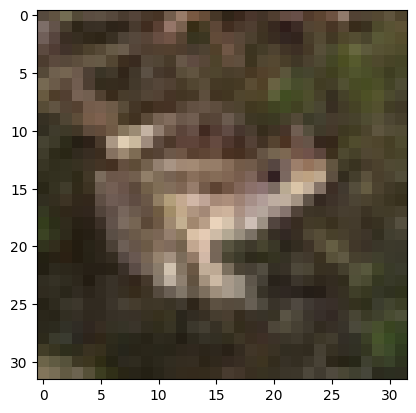

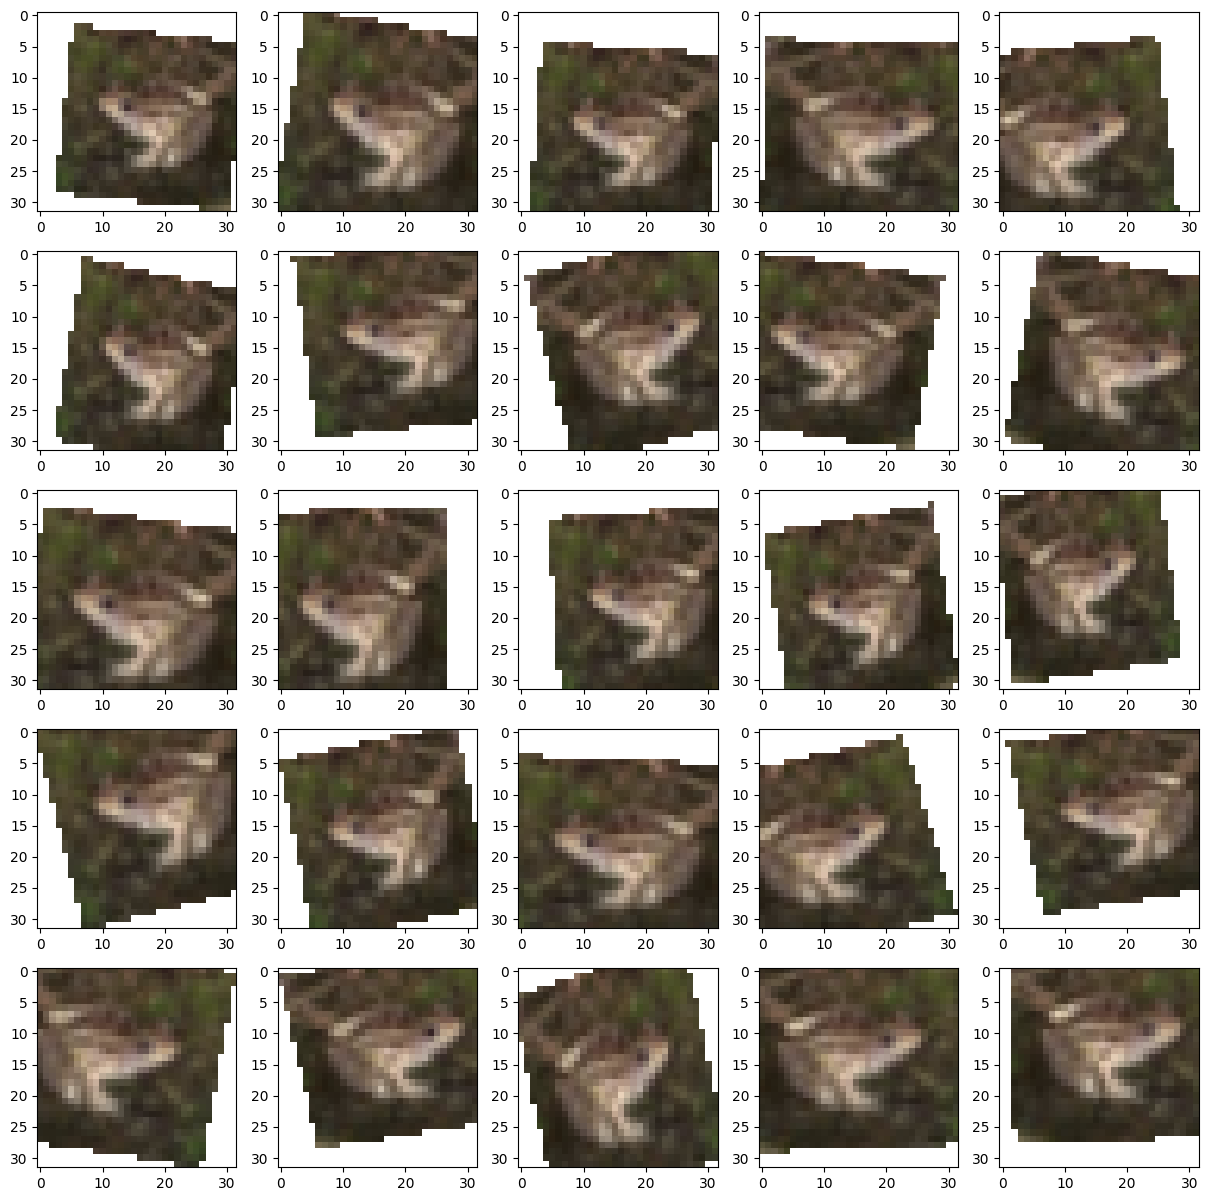

In [12]:
i=22
data_aug=datagen.flow(x=X_train_norm[i:(i+1)], y=Y_train[i:(i+1)], batch_size=1)
plt.imshow(X_train_norm[i])
plt.show()
plt.figure(figsize=(15,15))
for i in range (0,25):
    plt.subplot(5,5,i+1)
    x_aug,y_aug=next(data_aug)
    plt.imshow(x_aug[0], vmin = 0, vmax = 1)

In [13]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
            filepath = "./" + model_name + ".h5",
            verbose = 1,
            save_weights_only = True,
            monitor = "val_loss", #'val_acc',
            mode = 'min',
            save_best_only = True)

early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=200, restore_best_weights=True)

In [14]:
if train:
    hist = model.fit(
        datagen.flow(X_train_norm, Y_train, batch_size=64, shuffle=True), 
        steps_per_epoch=len(X_train_norm) / 64,
        epochs=750, 
        shuffle = True,
        validation_data=(X_val_norm, Y_val),
        verbose=1,
        callbacks=[checkpoint_cb, early_stopping_cb])

In [15]:
if train:    
    pkl.dump(hist.history, open("./" + model_name + "_history.pkl", "wb"), protocol=4)
    histplt = hist.history

if not train:
    histplt = pkl.load(open("./" + model_name + "_history.pkl", "rb"))

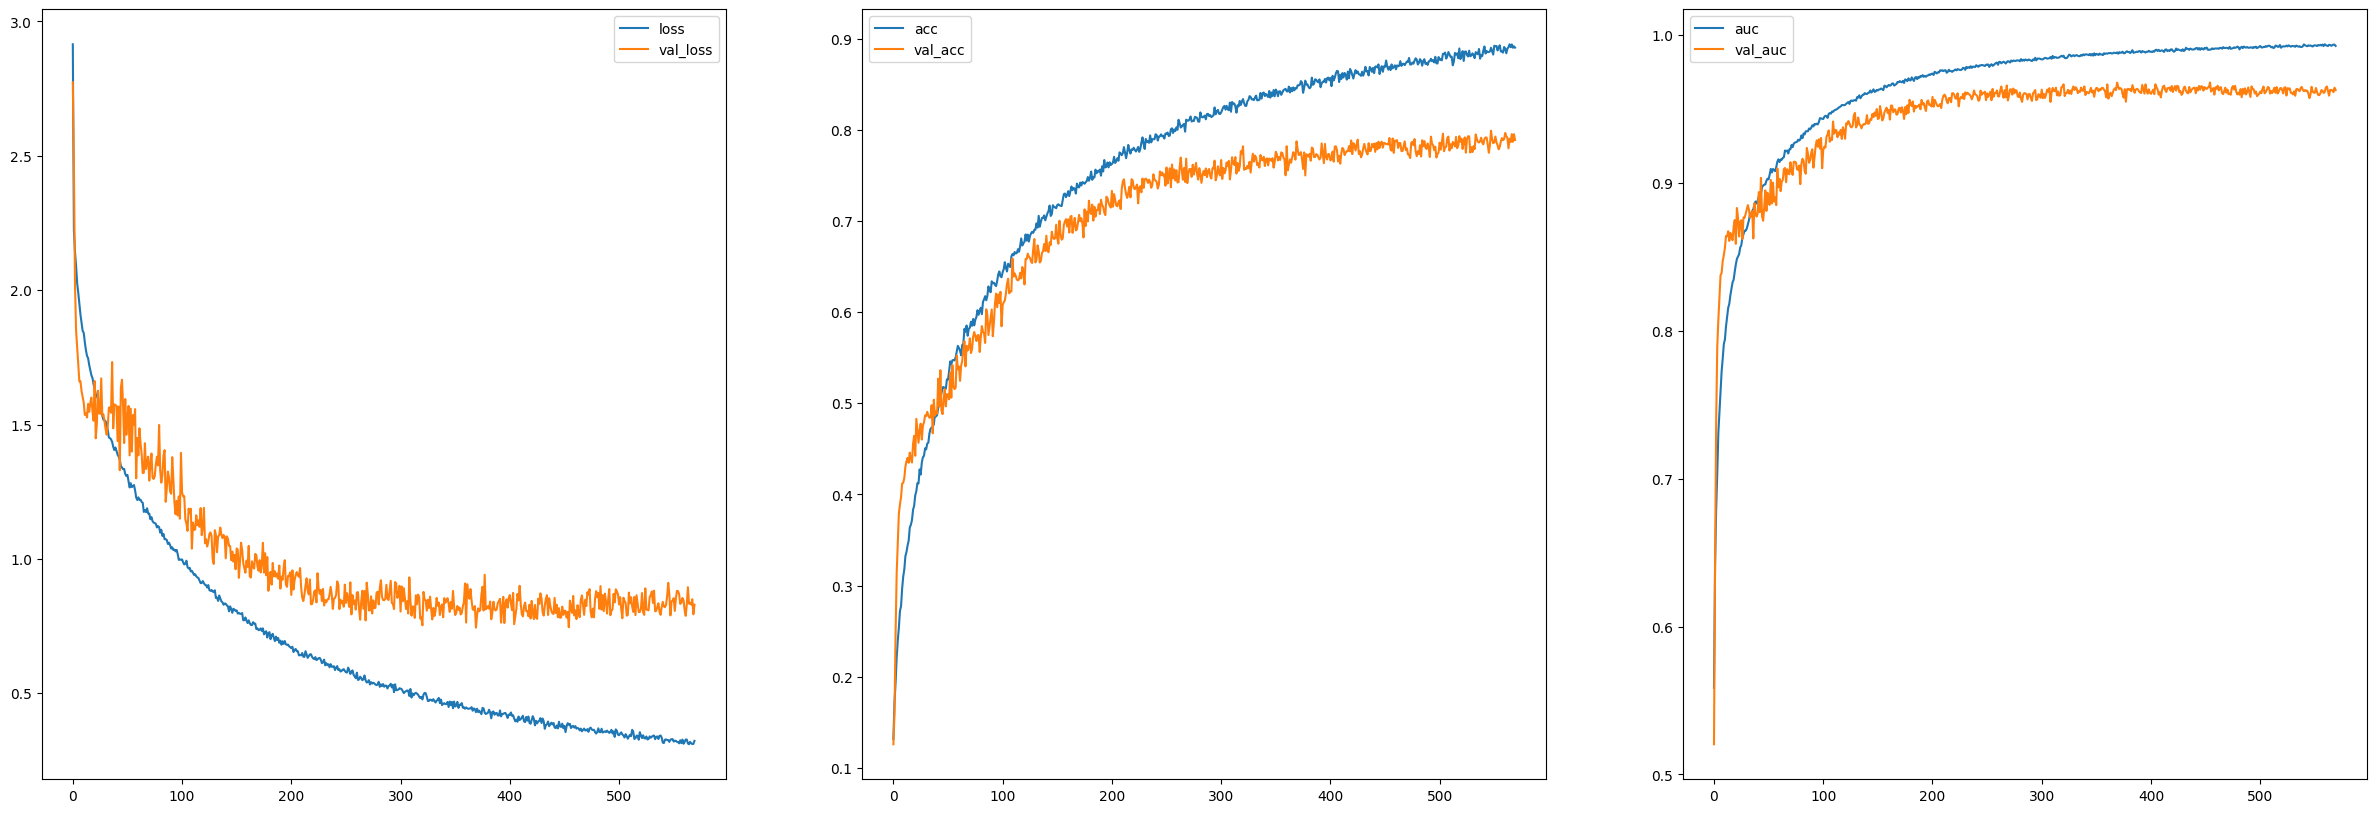

In [16]:
# plot training history
plt.figure(figsize = (30,10))
plt.subplot(1,3,1)
plt.plot(histplt['loss'], label = "loss")
plt.plot(histplt['val_loss'],label = "val_loss")
plt.legend()
plt.subplot(1,3,2)
plt.plot(histplt['acc'], label = "acc")
plt.plot(histplt['val_acc'],label = "val_acc")
plt.legend()
plt.subplot(1,3,3)
plt.plot(histplt['auc'], label = "auc")
plt.plot(histplt['val_auc'],label = "val_auc")
plt.legend()
plt.show()

In [17]:
model.load_weights("./" + model_name + ".h5")

In [18]:
model.evaluate(x=X_test_norm, y=Y_test, verbose = 0)

[0.8003541827201843, 0.7749999761581421, 0.9634507298469543]

In [19]:
acc=np.average(np.argmax(model.predict(X_test_norm),axis=1)==np.argmax(Y_test,axis=1))
res = pd.DataFrame(
          {'Acc' : acc}, index=['cnn']
)
res

,Acc
cnn,0.775
